In [1]:
import pandas as pd
import numpy as np

from metrics_f1 import calc_f1_score

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.subplots as sp
import seaborn as sns

from scipy.stats import kstest, spearmanr, mannwhitneyu, ttest_ind, levene, kruskal, chi2_contingency

def get_spearman(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

In [2]:
from ydata_profiling import ProfileReport


# Импорт данных и отчет

In [54]:
df = pd.read_csv('features (1).csv')

In [4]:
df.head()

,wagnum,prev_month,forecast_month,current_month,last_dep,last_kap,nearest_pl,wag_age,wag_remains,model,...,current_smerz,ost_prob,reestr_state,mileage_all,flange_sum,rim_sum,target_month,target_day,target_month_lag1,target_day_lag1
0,1071,2022-07-01,2022-09-01,2022-08-01,29.963654,257.963408,6.045299,8.865343,8148.0,11-1807-01,...,0.0,33933,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,1072,2022-07-01,2022-09-01,2022-08-01,32.000657,257.963408,4.008296,9.845514,8722.0,11-1807-01,...,0.0,13982,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,834,2022-07-01,2022-09-01,2022-08-01,13.010534,257.963408,22.998419,9.432090,8367.0,11-1807-01,...,0.0,106439,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,835,2022-07-01,2022-09-01,2022-08-01,22.965564,257.963408,13.010534,9.626481,8462.0,11-1807-01,...,0.0,85493,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,3205,2022-07-01,2022-09-01,2022-08-01,139.173289,257.963408,48.000986,-0.282004,11706.0,11-2163,...,0.0,448949,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [6]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_file("./hack.html")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df.columns

Index(['wagnum', 'prev_month', 'forecast_month', 'current_month', 'last_dep',
       'last_kap', 'nearest_pl', 'wag_age', 'wag_remains', 'model', 'rod_id',
       'gruz', 'cnsi_volumek', 'tara', 'cnsi_probeg_kr', 'cnsi_probeg_dr',
       'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km',
       'zavod_build', 'gr_probeg', 'por_probeg', 'tr_rems', 'pr_rems',
       'gr_distance', 'por_distance', 'isload', 'current_skoroport',
       'current_naval', 'current_nasip', 'current_naliv', 'current_openvagons',
       'current_soprovod', 'current_smerz', 'ost_prob', 'reestr_state',
       'mileage_all', 'flange_sum', 'rim_sum', 'target_month', 'target_day',
       'target_month_lag1', 'target_day_lag1'],
      dtype='object')

# EDA

## Типы грузов

In [17]:
numeric_loaded = ['isload', #доля нагруженных поездов 
'current_skoroport', #доля скоропортящихся 
'current_naval', #доля навальны грузов
'current_nasip', #доля насыпных
'current_naliv', # доля наливных 
'current_openvagons', #доля платформ
'current_soprovod', #доля нуждающися в сопровождении
 'current_smerz' #доля смерзшихся
                 ]

In [ ]:
'target_month', 'target_day',

In [18]:
correlation = df[numeric_loaded ].corr(method = 'spearman')
text = [[get_spearman(df[i], df[j]) for i in numeric_loaded ] for j in numeric_loaded ]

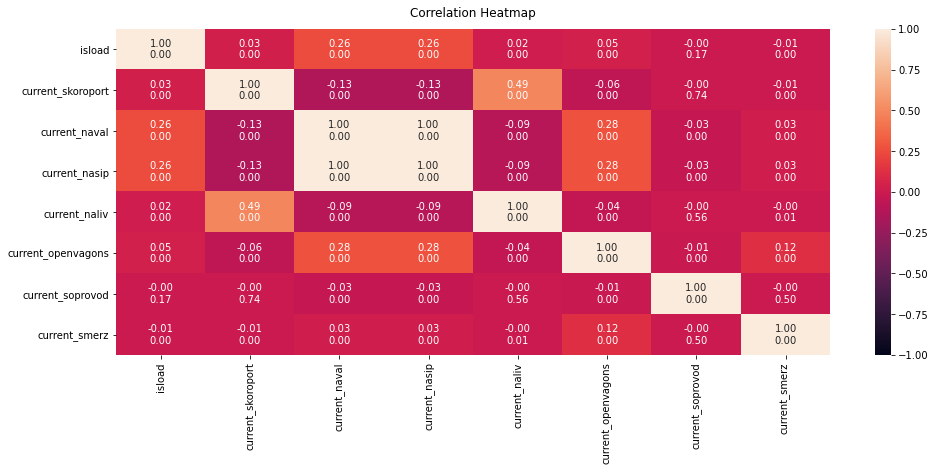

In [19]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=text, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("coor_gr.jpeg")

In [22]:
numeric_loaded = ['isload', #доля нагруженных поездов 
'current_skoroport', #доля скоропортящихся 
'current_naval', #доля навальны грузов
'current_naliv', # доля наливных 
'current_openvagons', #доля платформ
'current_soprovod', #доля нуждающися в сопровождении
 'current_smerz' #доля смерзшихся
                 ]

In [23]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_loaded:
    groups = [list(df[df.target_month == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'isload': [[0.438577452546633, 0.42842322786008347],
  [0.4333333333333333, 0.4193548387096774],
  MannwhitneyuResult(statistic=1005334252.5, pvalue=1.3992704053845898e-08),
  LeveneResult(statistic=67.31481927522728, pvalue=2.3276458452735766e-16)],
 'current_skoroport': [[0.009849434643137766, 0.005357617575709298],
  [0.0, 0.0],
  MannwhitneyuResult(statistic=983506342.0, pvalue=3.0407421676289553e-13),
  LeveneResult(statistic=35.73519143249526, pvalue=2.264180238892187e-09)],
 'current_naval': [[0.36735768688351805, 0.4543797303594045],
  [0.3870967741935484, 0.5161290322580645],
  MannwhitneyuResult(statistic=818553566.5, pvalue=7.028820808818969e-164),
  LeveneResult(statistic=404.2191337273309, pvalue=8.127406612659e-90)],
 'current_naliv': [[0.004442939973448771, 0.0012977513419387282],
  [0.0, 0.0],
  MannwhitneyuResult(statistic=979844484.5, pvalue=2.771843617759085e-12),
  LeveneResult(statistic=39.52485835440134, pvalue=3.2456294415667494e-10)],
 'current_openvagons': [[0

In [25]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_loaded:
    groups = [list(df[df.target_day == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], ttest_ind(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'isload': [[0.43841563465194494, 0.4175658585937196],
  [0.4333333333333333, 0.4193548387096774],
  Ttest_indResult(statistic=5.426529067747375, pvalue=5.752579114852102e-08),
  LeveneResult(statistic=30.7946863583692, pvalue=2.871777957218955e-08)],
 'current_skoroport': [[0.009686472985394313, 0.006073436610617045],
  [0.0, 0.0],
  Ttest_indResult(statistic=2.8090455920793507, pvalue=0.004969334307973806),
  LeveneResult(statistic=7.890737138380431, pvalue=0.004969334307965248)],
 'current_naval': [[0.3702985740548178, 0.45357139507539246],
  [0.3870967741935484, 0.5161290322580645],
  Ttest_indResult(statistic=-14.9293840564411, pvalue=2.256802710489646e-50),
  LeveneResult(statistic=177.69921456917808, pvalue=1.6025545311371042e-40)],
 'current_naliv': [[0.004344198436109624, 0.0008710450512660716],
  [0.0, 0.0],
  Ttest_indResult(statistic=4.05581347131878, pvalue=4.997870031860758e-05),
  LeveneResult(statistic=16.449622914130888, pvalue=4.9978700317715184e-05)],
 'current_openv

<AxesSubplot:xlabel='current_smerz', ylabel='Count'>

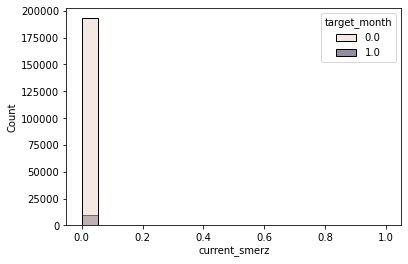

In [47]:
sns.histplot(data = df, x = 'current_smerz', hue = 'target_month' )

In [55]:
df['current_soprovod_cat'] = df.current_soprovod.apply(lambda x: 0 if x==0 else 1)
df['current_smerz_cat'] = df.current_smerz.apply(lambda x: 0 if x==0 else 1)

In [56]:
cat_gr = ['current_soprovod_cat','current_smerz_cat' ]

In [59]:
# Тестирование влияния с помощию Хи квадрата. 
#Сравнение распределений частот фактических и ожидаемых
crit_1 = 'target_month'

for crit_2 in cat_gr:
    ct = pd.crosstab(
        df[crit_1],
        df[crit_2])
    ct2 = pd.crosstab(
        df[crit_1],
        df[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

current_soprovod_cat 
 Кросс таблица 
 current_soprovod_cat       0    1
target_month                     
0.0                   193381  144
1.0                    10049    4 
 current_soprovod_cat         0         1
target_month                            
0.0                   0.950602  0.972973
1.0                   0.049398  0.027027 
 p-value: 0.29 

current_smerz_cat 
 Кросс таблица 
 current_smerz_cat       0    1
target_month                  
0.0                192914  611
1.0                 10030   23 
 current_smerz_cat         0         1
target_month                         
0.0                0.950577  0.963722
1.0                0.049423  0.036278 
 p-value: 0.15 



## По пробегам

In [14]:
numeric_dist = ['gr_probeg', #груженый пробег
'por_probeg', #порожний пробег  
'gr_distance', # расстояние груженый 
'por_distance', # расстояние порожний  
  'ost_prob', #остаточный пробег
'mileage_all' #средний пробег
]

In [7]:
correlation = df[numeric_dist ].corr(method = 'spearman')
text = [[get_spearman(df[i], df[j]) for i in numeric_dist ] for j in numeric_dist ]

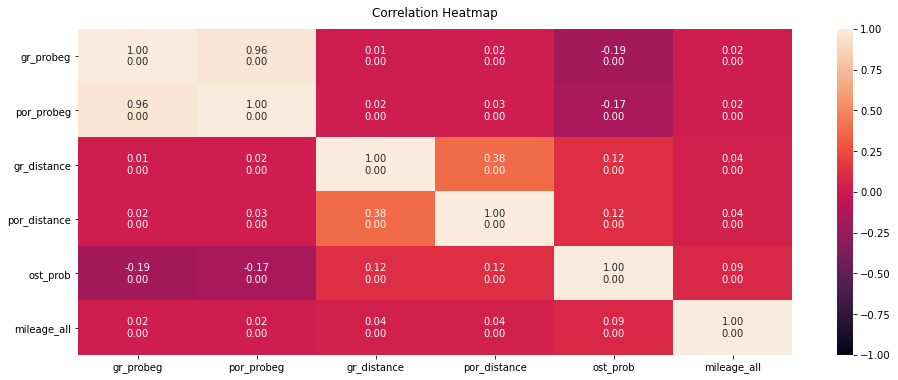

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=text, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("coor_prob.jpeg")

In [16]:
numeric_dist.remove('por_probeg')

In [17]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_dist:
    groups = [list(df[df.target_day == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'gr_probeg': [[38337.609759955856, 42428.11630454554],
  [32130.0, 6742.5],
  MannwhitneyuResult(statistic=313934243.0, pvalue=1.9435070548204658e-08),
  LeveneResult(statistic=422.7307299134532, pvalue=7.739278088276577e-94)],
 'gr_distance': [[543.4233937546143, 553.565733559929],
  [187.375, 207.83270676691728],
  MannwhitneyuResult(statistic=327614026.5, pvalue=0.18305228132988594),
  LeveneResult(statistic=0.03494120558311662, pvalue=0.851719099563704)],
 'por_distance': [[546.4859532257279, 575.5439434123779],
  [227.83333333333331, 275.7972709551657],
  MannwhitneyuResult(statistic=316252720.0, pvalue=2.243854741677779e-06),
  LeveneResult(statistic=0.4340350832878638, pvalue=0.5100163527381099)],
 'ost_prob': [[79996.93664299768, 7008.67400482509],
  [69610.5, 2782.0],
  MannwhitneyuResult(statistic=593754025.0, pvalue=0.0),
  LeveneResult(statistic=2684.7829448187863, pvalue=0.0)],
 'mileage_all': [[7999.267981856867, 14529.45474239857],
  [0.0, 0.0],
  MannwhitneyuResult(sta

In [18]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_dist:
    groups = [list(df[df.target_month == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'gr_probeg': [[38032.81605041153, 45554.29356990562],
  [32077.0, 17422.0],
  MannwhitneyuResult(statistic=874294521.0, pvalue=2.8362572694515143e-71),
  LeveneResult(statistic=2470.4581470331464, pvalue=0.0)],
 'gr_distance': [[543.6755537893235, 541.9146628362134],
  [186.48387096774192, 211.0],
  MannwhitneyuResult(statistic=952150779.5, pvalue=0.00028840199369433876),
  LeveneResult(statistic=2.6504977011772954, pvalue=0.10351902899951497)],
 'por_distance': [[545.9520455246097, 566.3487586885542],
  [226.6, 269.57142857142856],
  MannwhitneyuResult(statistic=935573815.0, pvalue=7.490345606499873e-11),
  LeveneResult(statistic=0.229732468925787, pvalue=0.6317227845881299)],
 'ost_prob': [[82447.10226068983, 8754.782055107928],
  [72795.0, 5107.0],
  MannwhitneyuResult(statistic=1733152484.0, pvalue=0.0),
  LeveneResult(statistic=7717.739521491941, pvalue=0.0)],
 'mileage_all': [[7753.893944290074, 14876.82790606555],
  [0.0, 0.0],
  MannwhitneyuResult(statistic=966583029.5, pvalue

<AxesSubplot:xlabel='mileage_all', ylabel='Count'>

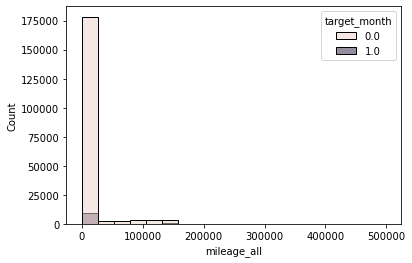

In [21]:
sns.histplot(data = df, x = 'mileage_all', hue = 'target_month')

<AxesSubplot:xlabel='tr_rems', ylabel='Count'>

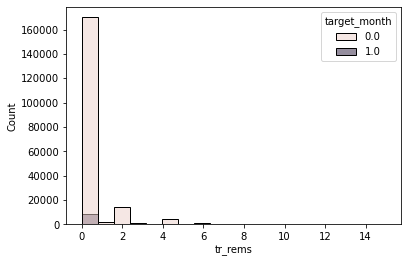

In [40]:
sns.histplot(data = df, x = 'tr_rems', hue = 'target_month')

In [41]:
df['mileage_cat'] = df.mileage_all.apply(lambda x: 0 if x==0 else 1)
df['tr_rems_cat'] = df.tr_rems.apply(lambda x: 0 if x==0 else 1)

In [42]:
cat_dist = ['mileage_cat', 'tr_rems_cat']

In [43]:
# Тестирование влияния с помощию Хи квадрата. 
#Сравнение распределений частот фактических и ожидаемых
crit_1 = 'target_month'

for crit_2 in cat_dist:
    ct = pd.crosstab(
        df[crit_1],
        df[crit_2])
    ct2 = pd.crosstab(
        df[crit_1],
        df[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

mileage_cat 
 Кросс таблица 
 mileage_cat        0      1
target_month               
0.0           173817  19708
1.0             9055    998 
 mileage_cat          0         1
target_month                    
0.0           0.950484  0.951801
1.0           0.049516  0.048199 
 p-value: 0.42 

tr_rems_cat 
 Кросс таблица 
 tr_rems_cat        0      1
target_month               
0.0           170036  23489
1.0             8913   1140 
 tr_rems_cat          0         1
target_month                    
0.0           0.950193  0.953713
1.0           0.049807  0.046287 
 p-value: 0.02 



In [44]:
# Тестирование влияния с помощию Хи квадрата. 
#Сравнение распределений частот фактических и ожидаемых
crit_1 = 'target_day'

for crit_2 in cat_dist:
    ct = pd.crosstab(
        df[crit_1],
        df[crit_2])
    ct2 = pd.crosstab(
        df[crit_1],
        df[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

mileage_cat 
 Кросс таблица 
 mileage_cat       0      1
target_day                
0.0          179875  20387
1.0            2997    319 
 mileage_cat         0         1
target_day                     
0.0          0.983611  0.984594
1.0          0.016389  0.015406 
 p-value: 0.3 

tr_rems_cat 
 Кросс таблица 
 tr_rems_cat       0      1
target_day                
0.0          175958  24304
1.0            2991    325 
 tr_rems_cat         0         1
target_day                     
0.0          0.983286  0.986804
1.0          0.016714  0.013196 
 p-value: 0.0 



## По ремонтам

In [35]:
cat_rem = ['target_month_lag1',  'target_day_lag1']

In [29]:
numeric_rem = [
'last_dep', #последний депо ремонт,
'last_kap', #последний капитальный ремонт
'nearest_pl', #ближайший плановый ремонт,
'tr_rems', #количество текущих ремонтов
'pr_rems' #количество плановых ремонтов
]

In [30]:
correlation = df[numeric_rem ].corr(method = 'spearman')
text = [[get_spearman(df[i], df[j]) for i in numeric_rem ] for j in numeric_rem ]

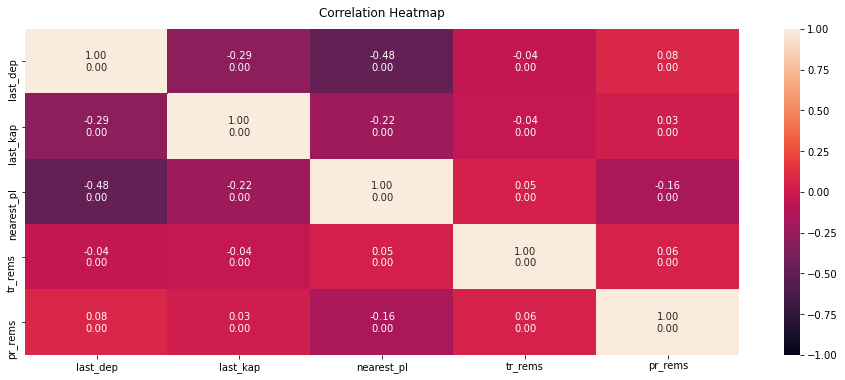

In [32]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=text, fmt='' )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("coor_rem.jpeg")

In [16]:
numeric_dist.remove('por_probeg')

In [33]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_rem:
    groups = [list(df[df.target_day == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'last_dep': [[35.19329242133533, 39.937707496464526],
  [27.992361239450503, 32.03351198176554],
  MannwhitneyuResult(statistic=247789954.5, pvalue=4.5113016433674466e-139),
  LeveneResult(statistic=81.33231060686393, pvalue=1.9237566989380426e-19)],
 'last_kap': [[149.46289481705475, 160.9321097068769],
  [149.94969095874657, 257.9634078728516],
  MannwhitneyuResult(statistic=308496811.0, pvalue=2.2129155374796277e-13),
  LeveneResult(statistic=0.04652574269410607, pvalue=0.8292231677188511)],
 'nearest_pl': [[14.176733188039247, 7.0438949326369595],
  [13.010534097209389, 6.965235425778763],
  MannwhitneyuResult(statistic=481474510.0, pvalue=0.0),
  LeveneResult(statistic=1651.5978113325677, pvalue=0.0)],
 'tr_rems': [[0.31905703528377827, 0.26085645355850423],
  [0.0, 0.0],
  MannwhitneyuResult(statistic=339841610.5, pvalue=3.965874174304908e-05),
  LeveneResult(statistic=11.301263429034103, pvalue=0.0007746861158571067)],
 'pr_rems': [[0.05211672708751536, 0.0015078407720144752],


In [34]:
# Проверка влияет ли количественный показатель на результат или нет. 
# Тестирование на нормальность распределений в каждой группе
# Тест средних (медиан) для двух независимых выборок. 
# Тестирование дисперсий

result = {}
for column in numeric_rem:
    groups = [list(df[df.target_month == i][column].values) for i in [0,1] ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]): 
        result[column] = [[np.mean(gr) for gr in groups], [np.median(gr) for gr in groups], mannwhitneyu(*groups, alternative = 'two-sided'), levene(*groups, center='median')]
    else: 
        result[column] = [ [gr.mean() for gr in groups], ttest_ind(*groups), levene(*groups, center='mean')]
result

{'last_dep': [[35.05288083730955, 39.46123554156992],
  [27.992361239450503, 32.000657097681675],
  MannwhitneyuResult(statistic=730308314.0, pvalue=0.0),
  LeveneResult(statistic=276.74242248374424, pvalue=4.232498177265471e-62)],
 'last_kap': [[149.22666932612543, 157.79348814310086],
  [149.02975420439844, 168.97266884330273],
  MannwhitneyuResult(statistic=917204234.5, pvalue=4.7905807602872644e-24),
  LeveneResult(statistic=17.897817049204964, pvalue=2.3319007173849444e-05)],
 'nearest_pl': [[14.410175248003698, 7.330083798848505],
  [13.010534097209389, 6.965235425778763],
  MannwhitneyuResult(statistic=1405679830.5, pvalue=0.0),
  LeveneResult(statistic=5006.7497003335775, pvalue=0.0)],
 'tr_rems': [[0.31776256297635963, 0.3247786730329255],
  [0.0, 0.0],
  MannwhitneyuResult(statistic=979446640.0, pvalue=0.03955880447981889),
  LeveneResult(statistic=0.48112922569036964, pvalue=0.4879120599711232)],
 'pr_rems': [[0.053915514791370626, 0.0007957823535263105],
  [0.0, 0.0],
  Man

<AxesSubplot:xlabel='mileage_all', ylabel='Count'>

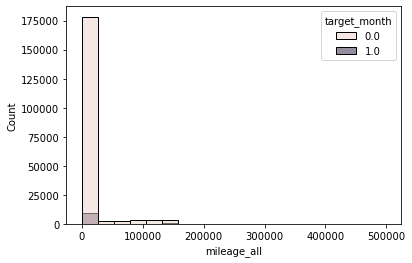

In [21]:
sns.histplot(data = df, x = 'mileage_all', hue = 'target_month')

In [37]:
# Тестирование влияния с помощию Хи квадрата. 
#Сравнение распределений частот фактических и ожидаемых
crit_1 = 'target_month'

for crit_2 in cat_rem:
    ct = pd.crosstab(
        df[crit_1],
        df[crit_2])
    ct2 = pd.crosstab(
        df[crit_1],
        df[crit_2], normalize = 'columns')
    
    print(crit_2, '\n Кросс таблица \n', ct,'\n', ct2, '\n p-value:', round(chi2_contingency(ct)[1],2), '\n')

target_month_lag1 
 Кросс таблица 
 target_month_lag1     0.0   1.0
target_month                   
0.0                152507  8684
1.0                  8410     0 
 target_month_lag1       0.0  1.0
target_month                    
0.0                0.947737  1.0
1.0                0.052263  0.0 
 p-value: 0.0 

target_day_lag1 
 Кросс таблица 
 target_day_lag1     0.0   1.0
target_month                 
0.0              158332  2859
1.0                8410     0 
 target_day_lag1       0.0  1.0
target_month                  
0.0              0.949563  1.0
1.0              0.050437  0.0 
 p-value: 0.0 

